# Chapter 7
## Moving Beyond Linearity

Relaxing the linearity assumption while still maintaining as much interpretibility as possible.

1. __Polynomial Regression__ :- Extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power.


2. __Step Functions__ :- Cut the range of a variable into K distinct regions in order to produce a qualitative variable. This has the effect of fitting a piecewise constant function.


3. __Regression Splines__ :- Dividing a variable to K distinct regions. Within each region, a polynomial is fit to data. The polynomial join smoothly at region boundaries called knots. 


4. __Smoothing Splines__ :- They result from minimizing a RSS criterion subject to smoothness penalty.


5. __Local Regression__ :- Similar to splines but the region are allowed to overlap.


6. __Generalized Additive Models__ :- Extend the above method to deal with multiple predictors.

### Polynomial Regression 
A polynomial regression model can be written as 
$$y_i = \beta_0 + \beta_1 x_{i} +  \beta_2 x_{i}^{2} +....+ \beta_d x_{i}^{d} + \epsilon_i$$
$\epsilon_i$ = error term.

large value of d means more flexible curve especially near the boundary of X. hence it is unusual to use d greater than 3 or 4. 

The coefficients can be estimated using least squares. Least squares returns varaince estimates for each fitted coefficients $\hat \beta_j$

If $l_o$ is the point estimate = $(1,x_0,x_{0}^{2},..)$ and C is the covaraince matrix then pointwise standard error can be written as $l_{0}^{T}Cl_0$.
This can be used to estimate the CI.


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [51]:
# Readin wage data in our environment.
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Wage.csv"
Wage = pd.read_csv(url, index_col = 0, error_bad_lines = False)
Wage["Wage_250"] = 0
Wage.loc[Wage.wage > 250, "Wage_250"] = 1 # Creating binary variable for logistic model

In [55]:
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y,xp).fit() # Fitting a linear model with polynomial terms

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,xp).fit() # Fitting a logistic regression model with polynomial terms


Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


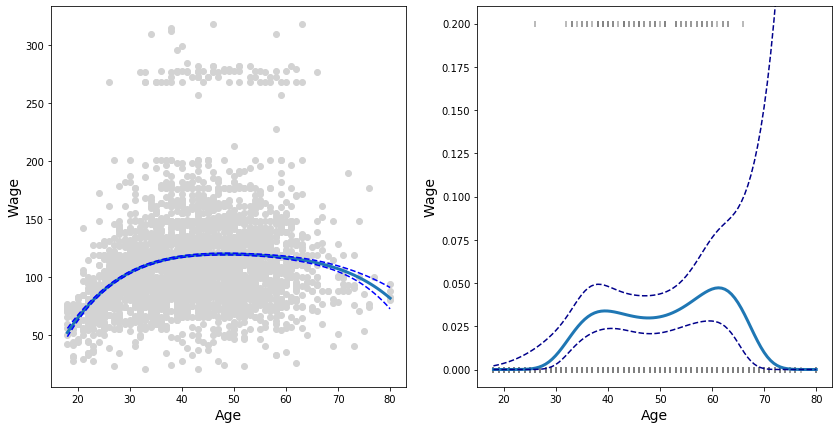

In [94]:
age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)
age_poly = polynomial_features.fit_transform(age_lin.reshape(-1,1))

prediction = model.get_prediction(age_poly) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age_lin, model.predict(age_poly), linewidth = 3.0)
ax1.plot(age_lin, ci.mean_ci_lower, linestyle = "--", color = "blue")
ax1.plot(age_lin, ci.mean_ci_upper, linestyle = "--", color = "blue")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(age_poly,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in age_poly])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age_lin, logit_model.predict(age_poly), linewidth = 3.0)
ax2.plot(age_lin, lower, linestyle = "--", color = "darkblue")
ax2.plot(age_lin, upper, linestyle = "--", color = "darkblue")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()